# Setup

In [0]:
!pip install OWSLib
!pip install geopandas

import os
from pathlib import Path
from getpass import getpass
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
import geopandas as gpd
from IPython.display import display

# Current working directory
%cd /content/drive/My Drive/unimelb-cluster-and-cloud-computing-comp90024-2020-sm1/city_analytics/geospatial

# Set environment variables
os.environ["AURIN_USERNAME"] = input("Please enter your AURIN username: ")
os.environ["AURIN_PASSWORD"] = getpass("Please enter your AURIN password: ")

# Global constants
DATADIR = Path("../geodata")
URL = "http://openapi.aurin.org.au/wfs"  # WFS source
LAYERNAMES = ["aurin:datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggregated_pop_and_dwelling_counts_census_2016"]  # typename (dataset ID)

/content/drive/My Drive/unimelb-cluster-and-cloud-computing-comp90024-2020-sm1/city_analytics/geospatial
Please enter your AURIN username: govhack
Please enter your AURIN password: ··········


# Download basemaps

In [0]:
def retrieve(url, filename, force=False):
  """
  Download url to filename
  url: link to network object
  filename: local file
  force: if True, overwrite existing filename
  """

  filename = Path(filename).resolve()  # to avoid symbolic link
  if not force and filename.exists():
    return filename

  filename.parent.mkdir(parents=True, exist_ok=True)  # make dirs if not exist
  filename, headers = urlretrieve(url, filename)

  return filename

# Download WFS data

In [0]:
def download_wfs(url, version="1.1.0", typename="", outputFormat="json",
                 filename="", force=False):
  """
  Download Web Feature Service (WFS) data to filename
  url: WFS url
  version: WFS version
  typename: layer name
  outputFormat: format of response data
  fname: output file. Defaults to typename, stored in data directory
  force: if True, overwrite existing filename
  """

  filename = Path(filename or f"{DATADIR}/{typename}.{outputFormat}").resolve()  # to avoid symbolic link
  if not force and filename.exists():
    return filename

  # Connect service
  wfs = WebFeatureService(url, version=version,
                          username=os.environ["AURIN_USERNAME"],
                          password=os.environ["AURIN_PASSWORD"])
  
  # Request data
  r = wfs.getfeature(typename=typename, outputFormat=outputFormat)

  # Save data
  filename.parent.mkdir(parents=True, exist_ok=True)  # make dirs if not exist
  filename.write_bytes(r.read())

  return filename

wfs_files = [download_wfs(URL, typename=name) for name in LAYERNAMES]

# Simplify geometry of WFS data (reduce size)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             89 non-null     object  
 1   sa4_code_2016  89 non-null     object  
 2   population     89 non-null     int64   
 3   dwelling       89 non-null     float64 
 4   area_sqkm      89 non-null     float64 
 5   sa4_name       89 non-null     object  
 6   state_name     89 non-null     object  
 7   geometry       89 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 5.7+ KB
None


,id,sa4_code_2016,population,dwelling,area_sqkm,sa4_name,state_name,geometry
0,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,101,218833,110671.0,51895.5631,Capital Region,New South Wales,"MULTIPOLYGON (((149.91630 -37.07400, 149.91620..."
1,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,102,327737,144386.0,1681.0724,Central Coast,New South Wales,"MULTIPOLYGON (((151.57270 -33.29070, 151.57140..."
2,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,103,206164,92830.0,70297.0604,Central West,New South Wales,"POLYGON ((150.14240 -32.34150, 150.16560 -32.3..."
3,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,104,136246,63414.0,13229.7578,Coffs Harbour - Grafton,New South Wales,"MULTIPOLYGON (((153.14540 -30.30180, 153.14530..."
4,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,105,113712,54295.0,339363.6925,Far West and Orana,New South Wales,"POLYGON ((148.67690 -29.50990, 148.80050 -29.5..."


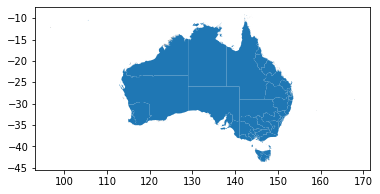

In [0]:
def simplify(filename, tolerance=0.01, preserve_topology=True):
  """
  Simplify geometry of filename to reduce size
  """
  
  # Clean data
  data = gpd.read_file(filename)
  data.dropna(subset=[data.geometry.name], inplace=True)  # remove na values from geometry

  data.geometry = data.geometry.simplify(tolerance, preserve_topology)  # simplify geometry
  data.to_file(filename, driver="GeoJSON")  # export data

  return filename

wfs_files_small = list(map(simplify, wfs_files))  # reduced size
data = gpd.read_file(wfs_files_small[0])
print(data.info())
display(data.head())
data.plot()

# References
https://data.aurin.org.au/dataset/au-govt-abs-sa4-aggregated-pop-and-dwelling-counts-census-2016-sa4-2016  
